In [1]:
# Suppression des warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [251]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
import lightgbm as lgb
from pycox.models import CoxPH, DeepHitSingle
from sklearn.impute import SimpleImputer
import torchtuples as tt
import torch

from sksurv.util import Surv

Le **Data Challenge de QRT**, en collaboration avec l’Institut Gustave Roussy, vise à prédire le risque de décès des patients atteints d’une leucémie myéloïde adulte en utilisant des données cliniques et moléculaires. La LMA est une forme de cancer du sang et de la moelle osseuse caractérisée par la prolifération rapide de cellules myéloïdes immatures. Ces cellules anormales s'accumulent dans la moelle osseuse, perturbant la production de cellules sanguines normales. L’objectif est de développer un outil de prédiction du risque de décès pour les patients diagnostiqués avec un cancer du sang. Cette métrique a pour vocation d'aider les soignants à adapter des stratégies thérapeutiques en adapter du profil des patients : haut ou faible risque, et ainsi améliorer leur prise en charge.

Nous allons travailler sur un **jeu de données** comprenant des informations de 3 323 patients en entraînement et 1 193 en test, issues de 24 centres cliniques. Deux types de données sont exploitées :
- **Données cliniques** (ex. taux de globules blancs, hémoglobine, anomalies chromosomiques).
- **Données moléculaires** (mutations génétiques et impact sur les protéines).

L’évaluation repose sur l’**IPCW-C-index**, une métrique adaptée aux données censurées. Un **modèle de risques proportionnels de Cox** sert de benchmark, comparé à un modèle LightGBM plus simple. L’objectif final est de soumettre des prédictions de risque de décès sous forme de fichier CSV.

Dans le cadre du cours de **machine learning**, nous travaillons sur ce projet pour développer des modèles prédictifs et améliorer la compréhension des approches en analyse de survie.

# Récupération des données : 

In [5]:
### Chargement des données train
Xtrain_clin = pd.read_csv("./clinical_train.csv")
Xtrain_mol = pd.read_csv("./molecular_train.csv")


Y_train = pd.read_csv("./target_train.csv")

### Chargement des données test
Xtest_clin = pd.read_csv("./clinical_test.csv")
Xtest_mol = pd.read_csv("./molecular_test.csv")

features = ['BM_BLAST', 'HB', 'PLT']
target = ['OS_YEARS', 'OS_STATUS']

# Présentation des dataset :

### Aperçu des données :

In [6]:
print(Xtrain_clin.head())
print(Xtrain_mol.head())

        ID CENTER  BM_BLAST    WBC  ANC  MONOCYTES    HB    PLT  \
0  P132697    MSK      14.0    2.8  0.2        0.7   7.6  119.0   
1  P132698    MSK       1.0    7.4  2.4        0.1  11.6   42.0   
2  P116889    MSK      15.0    3.7  2.1        0.1  14.2   81.0   
3  P132699    MSK       1.0    3.9  1.9        0.1   8.9   77.0   
4  P132700    MSK       6.0  128.0  9.7        0.9  11.1  195.0   

                          CYTOGENETICS  
0      46,xy,del(20)(q12)[2]/46,xy[18]  
1                                46,xx  
2   46,xy,t(3;3)(q25;q27)[8]/46,xy[12]  
3    46,xy,del(3)(q26q27)[15]/46,xy[5]  
4  46,xx,t(3;9)(p13;q22)[10]/46,xx[10]  
        ID CHR        START          END                REF ALT    GENE  \
0  P100000  11  119149248.0  119149248.0                  G   A     CBL   
1  P100000   5  131822301.0  131822301.0                  G   T    IRF1   
2  P100000   3   77694060.0   77694060.0                  G   C   ROBO2   
3  P100000   4  106164917.0  106164917.0           

# Données cliniques : 
- ID : Identifiant unique du patient.
- CENTER : Centre médical où le patient a été traité.
- BM_BLAST : Pourcentage de cellules blastiques dans la moelle osseuse (critère clé pour les leucémies).
- WBC : Nombre de globules blancs (White Blood Cell count).
- ANC : Nombre absolu de neutrophiles.
- MONOCYTES : Nombre de monocytes.
- HB : Niveau d’hémoglobine.
- PLT : Nombre de plaquettes sanguines.
- CYTOGENETICS : Anomalies cytogénétiques détectées.

Variables qualitatives : ID, Center, Cytogenetics

Varaibles quantitatives : BM_BLAST, WBC, ANC, MONOCTES, HB, PLT

# Données moléculaires
- ID : Identifiant unique du patient.
- CHR : Chromosome où la mutation a été détectée.
- START / END : Position génomique de la mutation.
- REF / ALT : Base de référence et base mutée.
- GENE : Nom du gène affecté.
- PROTEIN_CHANGE : Modification de la protéine codée.
- EFFECT : Effet de la mutation (non_synonymous_codon, stop_gained, etc.).
- VAF : Fréquence allélique de la mutation (proportion des copies de l’ADN affectées).
- DEPTH : Profondeur de lecture (nombre de fois que cette mutation a été détectée dans le séquençage).

Variables qualitatives : ID, CHR, REF, ALT, GENE, PROTEIN_CHANGE, EFFECT

Variables quantitatives : START, END, VAF, DEPTH

In [254]:
#print("Aperçu des données cible:")
#print(Y_train.head())

# Variable cible (survie des patiencts)
- ID : 
- OS_YEARS : Durée de survie en années après le diagnostic.
- OS_STATUS : Statut de survie lors du dernier suivi (0 = en vie, 1 = décédé).

# Description statistique des dataset.

Dans les extraits ci dessous, les descriptions statistiques ne peuvent s'effectuer que pour les varaibles quantitatives.

In [7]:
print("Description statistique des données :")
print(Xtrain_clin.describe())
print(Xtrain_mol.describe())

Description statistique des données :
          BM_BLAST          WBC          ANC    MONOCYTES           HB  \
count  3214.000000  3051.000000  3130.000000  2722.000000  3213.000000   
mean      5.982545     6.535164     3.264735     0.955868     9.893549   
std       7.615439    10.247219     5.237043     2.666478     2.041158   
min       0.000000     0.200000     0.000000     0.000000     4.000000   
25%       1.000000     2.700000     1.000000     0.150000     8.500000   
50%       3.000000     4.100000     2.000000     0.370000     9.700000   
75%       8.000000     6.655000     3.690000     0.783000    11.200000   
max      91.000000   154.400000   109.620000    44.200000    16.600000   

               PLT  
count  3199.000000  
mean    167.048900  
std     149.477031  
min       2.000000  
25%      65.500000  
50%     123.000000  
75%     229.500000  
max    1451.000000  
              START           END           VAF         DEPTH
count  1.082100e+04  1.082100e+04  10846.000

### Analyse des donnée cliniques pour le train :

- BM_BLAST :  On observe ci dessus que la moyenne observée du taux de blastes dans la moelle osseuse et de 5.98%, alors que la norme est inférieure à 5%. La moyenne observée est tout à fait cohérente avec la population étudiée ; des patient atteints de Leucémie Myéloïde par QRT. On remarque également que plus de la moitié de l'échantillon présente un taux inférieur à 3%, et qu'un quart de celui qui présente un taux supérieur à 8%, ce qui est anormalement élevé. Enfin, le maximum est à 91%, ce patient souffre d'une leucémie très aiguë. Toute valeure supérieure à 100% est impossible et se doit d'être modifié, or le dataset n'en présente aucune.
- WBC : Le taux de globules blancs dans le sang est en moyenne de 6.53 Giga/L, ce qui est dans la norme. Une quantité inférieure à 4 Giga/L indique un risque d'infection, alors qu'un volume supérieur à 11Giga/L indique une infection possible. Dans le cadre de l'échantillon; près de la moitié des patients présentent, au vu du taux de globules blancs, un risque d'infection.  Le maximum est à 154, ce ui est normalement élevé, mais reste inférieur au seuil possible de 200 Giga/L.
- ANC : Le nombre de neutrophiles est en moyenne de 3.26 Giga/L, ce qui est dans la norme (1.5 à 8 Giga/L). L'écart à la moyenne n'est pas très élevé. Un taux inférieur à 1.5 Giga/L indique un risque d’infection, alors qu’un taux supérieur à 10 Giga/L peut être lié à une infection grave ou à une maladie du sang. Le maximum observé est de 109.6 Giga/L, ce qui est très élevé et semble anormal. Toute valeur supérieure à 150 Giga/L est impossible et doit être corrigée.
- MONOCYTES : Le taux de monocytes est en moyenne de 0.95 Giga/L, ce qui est dans la norme (0.2 à 1 Giga/L). Une valeur supérieure à 1.5 Giga/L peut être un signe d’infection chronique ou d’un problème du sang. Un quart des patients a un taux élevé. Le maximum est de 44.2 Giga/L, ce qui est très anormal. Toute valeur supérieure à 50 Giga/L est impossible et doit être corrigée.
- HB : Le taux d’hémoglobine moyen est de 9.83 g/dL, alors que la norme est entre 12 et 17 g/dL. Plus de 75% de l'échntillon est en dessous de 12g/dL. C’est trop bas, ce qui indique une anémie. Une valeur inférieure à 7 g/dL est très dangereuse et peut nécessiter une transfusion. Le maximum est à 16.6 g/dL, ce qui reste normal. Toute valeur inférieure à 2 g/dL est impossible et doit être corrigée, or le minimum est à 4.
- PLT : Le taux moyen de plaquettes est de 167.5 Giga/L, ce qui est faible par rapport à la norme (150 - 450 Giga/L). Un taux inférieur à 150 Giga/L peut entraîner des problèmes de saignement, tandis qu’un taux supérieur à 450 Giga/L peut augmenter le risque de caillots sanguins.  Plus de la moitié des patiens présentent une quantité inférieure à 123Giga/L, ce qui est également cohérent avec la population étudiée. Le maximum observé est de 1451 Giga/L, ce qui est très élevé. Toute valeur supérieure à 2000 Giga/L est impossible et doit être corrigée.


- VAF : La moyenne observée de la fréquence allélique variant (VAF) est de 0.305, alors que les valeurs vont de 0.02 à 0.999. Cela signifie qu’en moyenne, environ 30% des copies d’ADN d’un patient portent la mutation, mais certains cas atteignent 99.9%, ce qui indique une mutation quasiment fixée. Un quart des patients ont une VAF supérieure à 44%, ce qui est élevé. Une valeur inférieure à 0 ou supérieure à 1 est biologiquement impossible et doit être corrigée, mais le dataset ne contient aucune valeur hors de ces limites.
- DEPTH : La profondeur moyenne de lecture (DEPTH) est de 1051, ce qui est un bon niveau pour une analyse fiable des mutations. Toutefois, certaines valeurs sont très élevées (max = 7156) et d’autres très faibles (min = 16), ce qui peut poser problème. Une profondeur trop basse (< 20-30) rend l’interprétation d’une mutation peu fiable, car il y a trop peu de séquences pour être certain du résultat. Une valeur supérieure à 10 000 pourrait indiquer une erreur technique.

Nous constatons que les analyses sanguins présentent statistiquement des écarts importants pour une grande partie des patiens étudiées. Ces valurs sont ohérentes avec le sujet. Enfin, aucunes valeurs incohérente n'est présente dans les dataset clinical_train et molecular_train.

# Traitement des données manquantes :

On observe énormément de valeurs manquantes dans les jeux de données. De ce fait, on calcul le nombres de NA. 

Ainsi, nous pourrons procéder au traitements de données selon la qualité de celle-ci.

On observe que toutes les variables présentent de valeurs manquantes .. sauf ID (clés), ...

La colonne Monoxyte et cytogenetics présentent un taux de NA très élevé, respectivement de 10% et de 20%.

In [8]:
print("Analyse des valeurs manquantes :")
print(Xtrain_mol.isna().sum())
print(Xtrain_clin.isna().sum())


Analyse des valeurs manquantes :
ID                  0
CHR               114
START             114
END               114
REF               114
ALT               114
GENE                0
PROTEIN_CHANGE     12
EFFECT              0
VAF                89
DEPTH             114
dtype: int64
ID                0
CENTER            0
BM_BLAST        109
WBC             272
ANC             193
MONOCYTES       601
HB              110
PLT             124
CYTOGENETICS    387
dtype: int64


In [9]:
Y_train = Y_train.dropna()

Au vu des types des variables, on s'assure que le typage soit correct en effectuant les transformations suivantes :

In [10]:
Xtrain_mol.head()
Xtrain_mol["ID"].value_counts()
Xtrain_mol["EFFECT"] = Xtrain_mol["EFFECT"].astype(str)

Y_train["OS_YEARS"] = Y_train["OS_YEARS"].astype(float)

Les ID sont les clés du jeu de données "Clinical". Toutefois, dans le jeu de donnée "Molecular", on constate des doublons sur la colonne ID, indiquant que différents marqueurs génétiques ou mutations ont été analysés pour un même individus.

 - La fréquence d'allèles variant (VAF) diffère parmi les entrées, indiquant que les niveaux de présence de ces mutations varient. Cela peut être dû à des différences dans l'échantillonnage ou la prévalence de la mutation dans différentes cellules de l'échantillon.
 - Le PROTEIN_CHANGE montre que les modifications protéiques dues aux mutations sont spécifiques à chaque entrée, ce qui souligne l'importance de chaque mutation unique dans l'analyse moléculaire.
 - Les champs START et END indiquent les positions exactes des mutations sur le chromosome, et bien que certaines puissent se chevaucher ou être identiques, les mutations elles-mêmes peuvent être différentes.

### Traitement de la colonne EFFECT : 

In [11]:
Xtrain_mol["EFFECT"].unique()

array(['non_synonymous_codon', 'stop_gained', 'splice_site_variant',
       'frameshift_variant', 'inframe_codon_loss', 'inframe_codon_gain',
       'initiator_codon_change', '2KB_upstream_variant',
       'complex_change_in_transcript', '3_prime_UTR_variant', 'stop_lost',
       'inframe_variant', 'synonymous_codon', 'stop_retained_variant',
       'ITD', 'PTD'], dtype=object)

On constate que la varaible EFFECT peut prendre 16 valeurs différentes. Celle-ci peuvent être catégoriser selon l'impact qu'elles ont sur la durrée de survie du patient et donc son risque de décés. On distingue les valeurs qui réduisent la durée de survie, et celle qui sont légèrement négative, neutre ou légèrement positive. Ainsi, on peut encoder les valeurs par -1 si l'impact est négatif et 0 si il ne l'est pas.

L'objectif de cette approche est de pouvoir agréger les effets des différentes mutations pour un même individus/ID dans le dataset Molecular, et ainsi obtenir une seule ligne par ID. En effet ce jeu de données présente plus de 10000lignes avec une répétition sur la majorité des ID.

Voici le résumé des impacts de chaque varaibles ci-dessous  :

Réduit la durée de survie :
- frameshift_variant
- stop_gained
- splice_site_variant
- ITD	Délétère
- initiator_codon_change
- stop_lost	Délétère
- complex_change_in_transcript	Délétère

Approximativement Neutre sur la durée de survie :
- non_synonymous_codon		
- inframe_codon_loss		
- inframe_codon_gain		
- inframe_variant
- PTD		
- synonymous_codon	Neutre	
- stop_retained_variant	Neutre	
- 3_prime_UTR_variant	Neutre	
- 2KB_upstream_variant	Neutre	

Nous proposons ci dessous la fonction permettant de faire la transformation et le résultat appliqué à la colonne EFFECT.


In [12]:

def categorize_effect(effect_value):
    # Liste des effets qui réduisent la survie
    detrimental_effects = [
        "frameshift_variant", "stop_gained", "splice_site_variant", "ITD", 
        "initiator_codon_change", "stop_lost", "complex_change_in_transcript"
    ]
    
    # Liste des effets qui peuvent être neutres ou à impact variable
    neutral_effects = [
        "non_synonymous_codon", "inframe_codon_loss", "inframe_codon_gain", 
        "inframe_variant", "PTD"
    ]
    
    # Liste des effets neutres (aucun impact sur la survie)
    benign_effects = [
        "synonymous_codon", "stop_retained_variant", "3_prime_UTR_variant", "2KB_upstream_variant"
    ]
    
    # Catégorisation selon l'impact sur la survie
    if effect_value in detrimental_effects:
        return -1  # Réduit la survie
    elif effect_value in neutral_effects or effect_value in benign_effects:
        return 0  # Neutre ou peut réduire la survie, mais pas significatif
    else:
        return None  # Si la valeur est inconnue ou mal formée

# Appliquer la fonction à la colonne 'EFFECT' de votre DataFrame
Xtrain_mol['EFFECT'] = Xtrain_mol['EFFECT'].apply(categorize_effect)

# Afficher le résultat
print(Xtrain_mol[["ID",'EFFECT']])


            ID  EFFECT
0      P100000       0
1      P100000      -1
2      P100000      -1
3      P100000       0
4      P100000      -1
...        ...     ...
10930  P131472       0
10931  P131505       0
10932  P131816       0
10933  P132717       0
10934  P132724       0

[10935 rows x 2 columns]


# Traitement de la colonne "CYTOGENETICS"

In [13]:
Xtest_clin["CYTOGENETICS"].value_counts

<bound method IndexOpsMixin.value_counts of 0                     47,XY,+X,del(9)(q?)[15]/47,XY,+X[5]
1       46,XY,der(3)?t(3;11)(q26.2;q23),add(4)(p15).de...
2                                                47,XX,+8
3                                                  Normal
4       43,XY,dic(5;17)(q11.2;p11.2),-7,-13,-20,-22,+r...
                              ...                        
1188                                                  NaN
1189                                                  NaN
1190                                                  NaN
1191                                                  NaN
1192                                                  NaN
Name: CYTOGENETICS, Length: 1193, dtype: object>

Nous observons que cette la colonne CYTOGENETICS présente 1193 valeures distinctes, pour seulement 3223lignes dans le dataset. Deplus les valeurs de ce champ présente différentes informations, dont :
- Le nombre de chromosommes.
- Le sexe du patients.
- Le nombre d'échantillons ADN testés.
- Les anomalies detectées.

Dasn un soucis de simplification, nous décidons de créer 4 colonnes distinctes pour représenter ces informations séparément. 

In [14]:
def extract_sex(cytogenetics):
    if pd.isna(cytogenetics):
        return "AUTRE"
    elif "xx" in cytogenetics:
        return "HOMME"
    elif "xy" in cytogenetics:
        return "FEMME"
    else:
        return "AUTRE"

In [15]:
def parse_cytogenetics(cyto):
    cyto = str(cyto).lower()  # Convertir en string et mettre en minuscule

    # 1 Extraire le nombre de chromosomes
    chrom_match = re.search(r"\b(40|41|42|43|44|45|46|47|48|49|50)\b", cyto)
    num_chromosomes = int(chrom_match.group()) if chrom_match else None

    # 2️ Utiliser la fonction existante pour déterminer le sexe
    sexe = extract_sex(cyto)  # Remplacement par la fonction existante

    # 3️ Extraire le nombre d’échantillons testés
    sample_match = re.search(r"\[(\d+)\]", cyto)
    num_samples = int(sample_match.group(1)) if sample_match else None

    # 4️ Détection des anomalies (nouvelle logique)
    has_anomaly = 0  # Par défaut, pas d’anomalie
    if num_chromosomes and num_chromosomes != 46:
        has_anomaly = 1
    if re.match(r"^(46,xy(\[\d+\])?|46,xx(\[\d+\])?)$", cyto) is None:
        has_anomaly = 1

    return pd.Series([num_chromosomes, sexe, num_samples, has_anomaly])

# Appliquer la fonction au DataFrame (assurez-vous que 'train_set_clin' contient une colonne 'CYTOGENETICS')
Xtrain_clin[["Nombre_Chromosomes", "SEX", "Nb_Echantillons", "Anomalies"]] = Xtrain_clin["CYTOGENETICS"].apply(parse_cytogenetics)

In [16]:
Xtrain_clin["SEX"] = Xtrain_clin["CYTOGENETICS"].apply(extract_sex)
print(Xtrain_clin["SEX"].value_counts())

SEX
FEMME    1693
HOMME    1145
AUTRE     485
Name: count, dtype: int64


# Transformation du jeu de donnée Molecular

Nous pouvons désormais aggréger les lignes du jeu de donnée Molecular.
Nous décidons de calculer la moyenne des fréquences d'allèles variant, la profondeur et l'impact des effects de l'ensemble des mutations pour chaque identifiants.
Cette approche permet de conserver une information suffisemment détaillé pour chaque patiens tout en offrant la possilité de faire fusionner les deux jeux de données.   

In [17]:
aggregated_data = Xtrain_mol.groupby('ID').agg({
    'VAF': 'mean',  # Moyenne des fréquences d'allèles variant
    'DEPTH': 'sum',
    'EFFECT': 'sum' # Somme des profondeurs de séquençage 
}).reset_index()

In [267]:
#Xtrain_mol1 = Xtrain_mol.drop_duplicates(subset="ID", keep = False)
#Xtest_mol = Xtest_mol.drop_duplicates(subset="ID", keep=False)

In [268]:
#Xtrain_mol1["ID"].value_counts()

### MERGE INNER DES JEUX DE DONNEES

In [18]:
print(Xtrain_clin.shape)
print(aggregated_data.shape)

(3323, 13)
(3026, 4)


On conserve l'intersection des deux jeux de données (inner join) pour procéder à l'aggrégation de ces deux derniers.

In [20]:
#Merge la data VERIFIER NB ROWS PAR DATAFRAME
data_train = Xtrain_clin.merge(aggregated_data, on='ID', how = "inner")
#X_test = Xtest_clin.merge(aggregated_data, on='ID', how='outer')
data_train[["HB", "PLT", "BM_BLAST"]]  = data_train[["HB", "PLT", "BM_BLAST"]].astype(float)

In [21]:
# Types des variables
data_train.dtypes

ID                     object
CENTER                 object
BM_BLAST              float64
WBC                   float64
ANC                   float64
MONOCYTES             float64
HB                    float64
PLT                   float64
CYTOGENETICS           object
Nombre_Chromosomes    float64
SEX                    object
Nb_Echantillons       float64
Anomalies               int64
VAF                   float64
DEPTH                 float64
EFFECT                  int64
dtype: object

In [22]:
data_train.drop(columns=["CYTOGENETICS"], inplace=True) # suppression de la colonne CYTOGENETICS

Le dataset train est le suivant :

In [23]:
data_train

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,Nombre_Chromosomes,SEX,Nb_Echantillons,Anomalies,VAF,DEPTH,EFFECT
0,P132697,MSK,14.0,2.80,0.20,0.70,7.6,119.0,46.0,FEMME,2.0,1,0.251578,15374.0,-4
1,P132698,MSK,1.0,7.40,2.40,0.10,11.6,42.0,46.0,HOMME,NaN,0,0.272867,4204.0,-3
2,P116889,MSK,15.0,3.70,2.10,0.10,14.2,81.0,46.0,FEMME,8.0,1,0.039333,5309.0,-2
3,P132699,MSK,1.0,3.90,1.90,0.10,8.9,77.0,46.0,FEMME,15.0,1,0.209227,12605.0,-4
4,P132700,MSK,6.0,128.00,9.70,0.90,11.1,195.0,46.0,HOMME,10.0,1,0.472100,713.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3021,P121828,VU,1.0,3.70,2.53,0.53,8.9,499.0,46.0,FEMME,20.0,0,0.397000,1395.0,-1
3022,P121829,VU,0.0,4.20,2.40,0.22,10.6,49.0,46.0,FEMME,1.0,1,0.042000,743.0,0
3023,P121830,VU,0.0,1.80,0.55,0.29,9.4,86.0,46.0,FEMME,4.0,1,0.244650,4613.0,-3
3024,P121853,VU,5.0,1.37,0.37,0.11,11.4,102.0,46.0,HOMME,5.0,1,0.184250,5546.0,0


In [24]:
data_train['EFFECT'] = data_train['EFFECT'].apply(lambda x: "négatif" if x < 0 else "neutre")
data_train

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,Nombre_Chromosomes,SEX,Nb_Echantillons,Anomalies,VAF,DEPTH,EFFECT
0,P132697,MSK,14.0,2.80,0.20,0.70,7.6,119.0,46.0,FEMME,2.0,1,0.251578,15374.0,négatif
1,P132698,MSK,1.0,7.40,2.40,0.10,11.6,42.0,46.0,HOMME,NaN,0,0.272867,4204.0,négatif
2,P116889,MSK,15.0,3.70,2.10,0.10,14.2,81.0,46.0,FEMME,8.0,1,0.039333,5309.0,négatif
3,P132699,MSK,1.0,3.90,1.90,0.10,8.9,77.0,46.0,FEMME,15.0,1,0.209227,12605.0,négatif
4,P132700,MSK,6.0,128.00,9.70,0.90,11.1,195.0,46.0,HOMME,10.0,1,0.472100,713.0,négatif
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3021,P121828,VU,1.0,3.70,2.53,0.53,8.9,499.0,46.0,FEMME,20.0,0,0.397000,1395.0,négatif
3022,P121829,VU,0.0,4.20,2.40,0.22,10.6,49.0,46.0,FEMME,1.0,1,0.042000,743.0,neutre
3023,P121830,VU,0.0,1.80,0.55,0.29,9.4,86.0,46.0,FEMME,4.0,1,0.244650,4613.0,négatif
3024,P121853,VU,5.0,1.37,0.37,0.11,11.4,102.0,46.0,HOMME,5.0,1,0.184250,5546.0,neutre


# Application des même transformations dans le dataset test : 

Afin de pouvoir effectuer un backtest du modèle, nous avons besoin que les données de jeux de test soient traiter de la même manière. Nous répétons donc les mêmes procédures ci dessous :

In [25]:
print("Analyse des valeurs manquantes :")
print(Xtest_mol.isna().sum())
print(Xtest_clin.isna().sum())

Analyse des valeurs manquantes :
ID                 0
CHR               69
START             69
END               69
REF               69
ALT               69
GENE               0
PROTEIN_CHANGE    46
EFFECT            90
VAF                0
DEPTH             69
dtype: int64
ID                0
CENTER            0
BM_BLAST        115
WBC             112
ANC             141
MONOCYTES       883
HB              111
PLT             115
CYTOGENETICS    116
dtype: int64


In [26]:
Xtest_mol["ID"].value_counts()
Xtest_mol["EFFECT"] = Xtest_mol["EFFECT"].astype(str)

### Traitement de la colonne EFFECT (data_test) : 

In [33]:
# Appliquer la fonction à la colonne 'EFFECT' de votre DataFrame
Xtest_mol['EFFECT'] = Xtest_mol['EFFECT'].apply(categorize_effect)

# Afficher le résultat
print(Xtest_mol[["ID",'EFFECT']])

           ID  EFFECT
0      KYW961     0.0
1      KYW142     0.0
2      KYW453     0.0
3      KYW982     0.0
4      KYW845    -1.0
...       ...     ...
3084  KYW1077     0.0
3085  KYW1084     0.0
3086  KYW1082     0.0
3087  KYW1085     0.0
3088  KYW1095     0.0

[3089 rows x 2 columns]


### Traitement de la colonne "CYTOGENETICS" (data_test)

In [39]:
# Appliquer la fonction au DataFrame (assurez-vous que 'train_set_clin' contient une colonne 'CYTOGENETICS')
Xtest_clin[["Nombre_Chromosomes", "SEX", "Nb_Echantillons", "Anomalies"]] = Xtest_clin["CYTOGENETICS"].apply(parse_cytogenetics)
# Xtrain_clin["SEX"] = Xtrain_clin["CYTOGENETICS"].apply(extract_sex)
print(Xtest_clin["SEX"].value_counts())


SEX
FEMME    554
AUTRE    417
HOMME    222
Name: count, dtype: int64


### Transformation du jeu de donnée Molecular (data_test)

In [34]:
aggregated_data = Xtest_mol.groupby('ID').agg({
    'VAF': 'mean',  # Moyenne des fréquences d'allèles variant
    'DEPTH': 'sum',
    'EFFECT': 'sum' # Somme des profondeurs de séquençage 
}).reset_index()

### Merge (inner join) (data_test)

In [35]:
#Merge la data VERIFIER NB ROWS PAR DATAFRAME
data_test = Xtest_clin.merge(aggregated_data, on='ID', how = "inner")
#X_test = Xtest_clin.merge(aggregated_data, on='ID', how='outer')
data_test[["HB", "PLT", "BM_BLAST"]]  = data_test[["HB", "PLT", "BM_BLAST"]].astype(float)

In [40]:
data_test.drop(columns=["CYTOGENETICS"], inplace=True) # suppression de la colonne CYTOGENETICS

In [36]:
data_test['EFFECT'] = data_test['EFFECT'].apply(lambda x: "négatif" if x < 0 else "neutre")


In [41]:
data_test

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,Nombre_Chromosomes,SEX,Nb_Echantillons,Anomalies,VAF,DEPTH,EFFECT
0,KYW1,KYW,68.0,3.45,0.5865,NaN,7.6,48.0,47.0,FEMME,15.0,1,0.246225,1642.0,négatif
1,KYW2,KYW,35.0,3.18,1.2402,NaN,10.0,32.0,46.0,FEMME,20.0,1,0.281000,2099.0,négatif
2,KYW3,KYW,NaN,12.40,8.6800,NaN,12.3,25.0,47.0,HOMME,NaN,1,0.162667,3383.0,négatif
3,KYW4,KYW,61.0,5.55,2.0535,NaN,8.0,44.0,NaN,AUTRE,NaN,1,0.351367,2486.0,négatif
4,KYW5,KYW,2.0,1.21,0.7381,NaN,8.6,27.0,43.0,FEMME,12.0,1,0.263667,2447.0,négatif
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049,KYW1189,KYW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AUTRE,NaN,1,0.445500,1305.0,neutre
1050,KYW1190,KYW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AUTRE,NaN,1,0.438667,655.0,négatif
1051,KYW1191,KYW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AUTRE,NaN,1,0.122000,937.0,neutre
1052,KYW1192,KYW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AUTRE,NaN,1,0.305667,1522.0,négatif


# Selection des features

In [275]:
# Create the survival data format
#X = data_train.loc[data_train['ID'].isin(Y_train['ID']), features]
#y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', Y_train)

In [276]:
#Fonction pour préparation de données
def clean_data(data, columns):
    data_cleaned = data.dropna(subset = columns)
    return data_cleaned

In [277]:
target_data = Y_train.dropna()
target_data['OS_YEARS'] = pd.to_numeric(target_data['OS_YEARS'], errors='coerce')
target_data['OS_STATUS'] = target_data['OS_STATUS'].astype(bool).astype(int)
target_data = target_data.dropna()

In [278]:
data_train = data_train[data_train["ID"].isin(target_data["ID"])]

In [279]:
#il faut regrouper en personnes ayant vécu 0 à 2 ans de 2ans à 4 ...
En_vie = target_data[target_data["OS_STATUS"]==1.0]
Mort = target_data[target_data["OS_STATUS"]==0.0]

En_vie = En_vie.drop(columns = ["OS_STATUS"])
Mort = Mort.drop(columns = ["OS_STATUS"])

#ICI ON PEUT PRESENTER COMME SUIT 


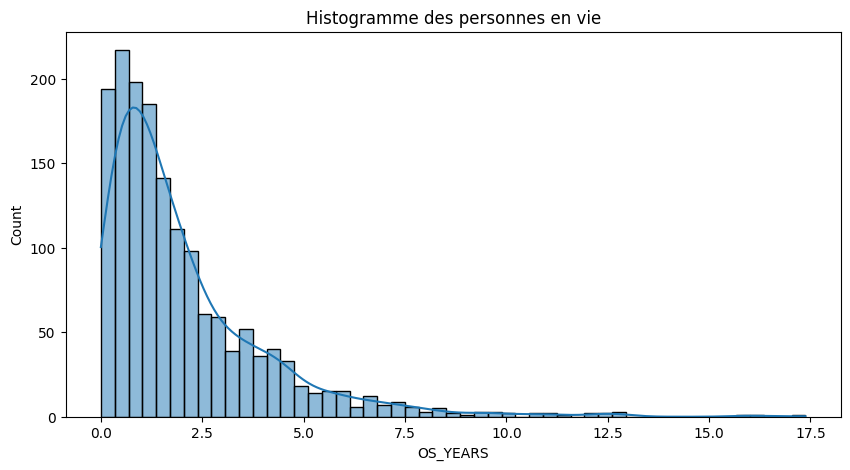

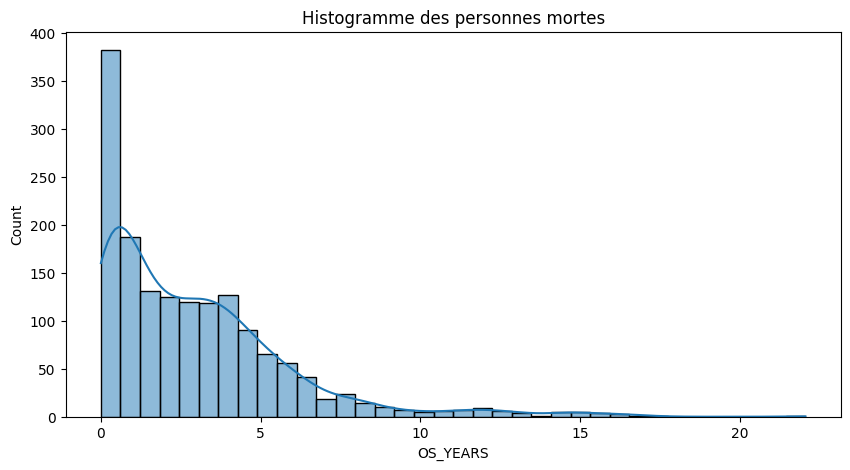

In [280]:
def Histogramme_function(data, title):
    plt.figure(figsize=(10, 5))
    sns.histplot(data, kde=True)
    plt.title(title)
    plt.show()

Histogramme_function(En_vie["OS_YEARS"], "Histogramme des personnes en vie")
Histogramme_function(Mort["OS_YEARS"], "Histogramme des personnes mortes")

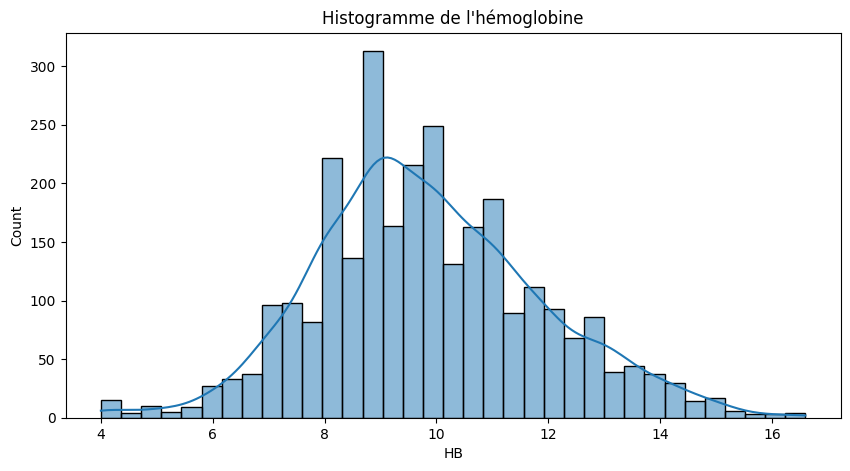

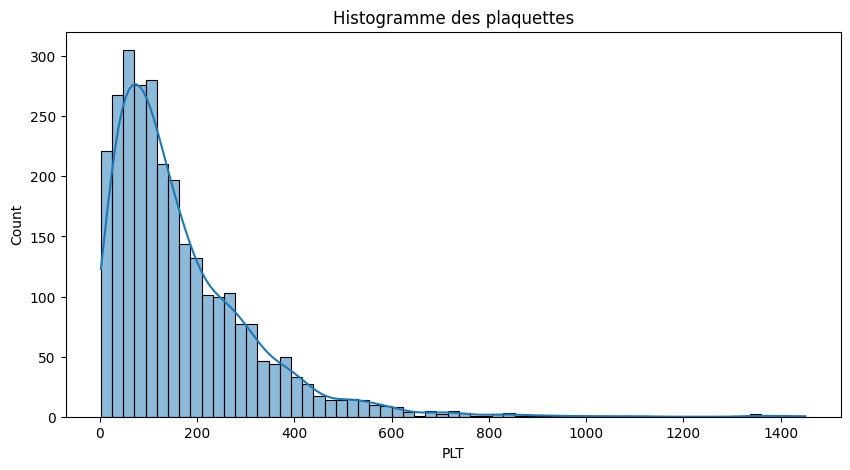

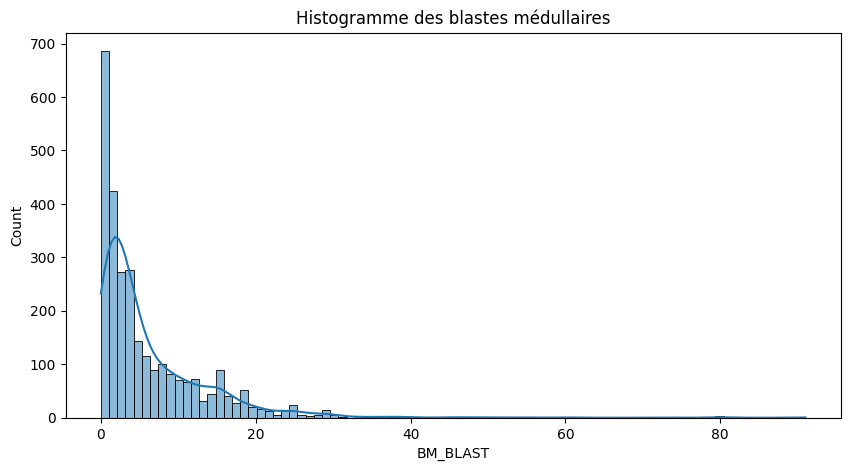

In [281]:
Histogramme_function(data_train["HB"], "Histogramme de l'hémoglobine") 
Histogramme_function(data_train["PLT"], "Histogramme des plaquettes")
Histogramme_function(data_train["BM_BLAST"], "Histogramme des blastes médullaires")

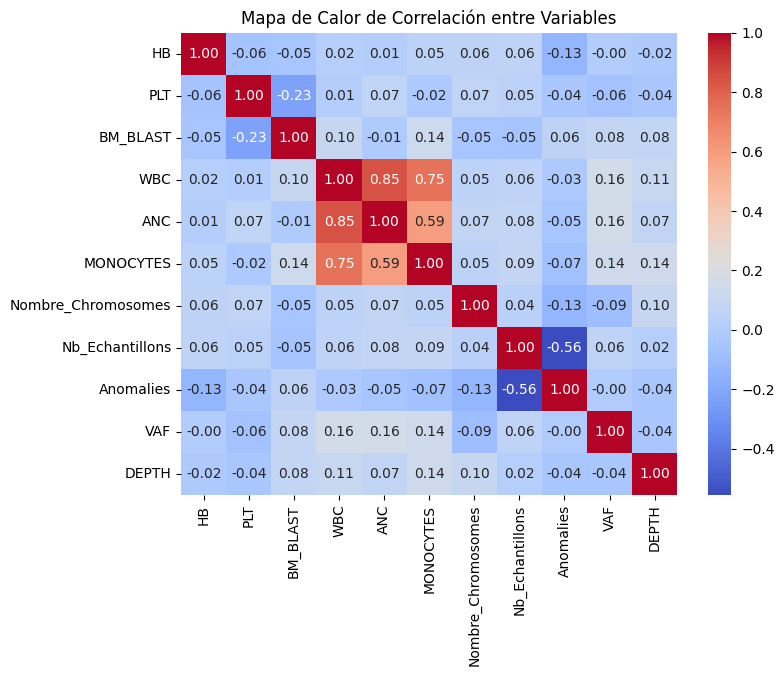

In [282]:
# Calculando la matriz de correlación
correlation_matrix = data_train[['HB', 'PLT', 'BM_BLAST','WBC','ANC','MONOCYTES','Nombre_Chromosomes',	'Nb_Echantillons',	'Anomalies',	'VAF',	'DEPTH']].corr()

# Creando el mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Mapa de Calor de Correlación entre Variables')
plt.show()


- La variable ANC est très corrélé au variables ANC et Monocytes. On propose donc de conserver la variables WBC pour représenter ces trois variables. 
- On conserve également la variable HB, qui n'est que très faiblement corrélé aux autres varaibles
- Les variables PLT et BM_BLAST présentent également une corrélation élevé. On décide de conserver PLT, car cette variable indique un état de sans négatif pour une plus grande partie de l'échantillon que BM_BLAST
- Nous proposons enfin de conserver nombre de chromosomme, car c'est la variable qui représente le mieux les variables Anomalie, DEPTH et EFFECT 

In [283]:
data_train

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,Nombre_Chromosomes,SEX,Nb_Echantillons,Anomalies,VAF,DEPTH,EFFECT
0,P132697,MSK,14.0,2.80,0.20,0.70,7.6,119.0,46.0,FEMME,2.0,1,0.251578,15374.0,négatif
1,P132698,MSK,1.0,7.40,2.40,0.10,11.6,42.0,46.0,HOMME,NaN,0,0.272867,4204.0,négatif
2,P116889,MSK,15.0,3.70,2.10,0.10,14.2,81.0,46.0,FEMME,8.0,1,0.039333,5309.0,négatif
3,P132699,MSK,1.0,3.90,1.90,0.10,8.9,77.0,46.0,FEMME,15.0,1,0.209227,12605.0,négatif
4,P132700,MSK,6.0,128.00,9.70,0.90,11.1,195.0,46.0,HOMME,10.0,1,0.472100,713.0,négatif
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3019,P121826,VU,1.0,2.50,1.02,0.20,10.2,78.0,47.0,FEMME,10.0,1,0.169000,4588.0,neutre
3020,P121827,VU,1.5,8.10,2.66,0.45,11.3,40.0,44.0,HOMME,20.0,1,0.427500,1869.0,neutre
3023,P121830,VU,0.0,1.80,0.55,0.29,9.4,86.0,46.0,FEMME,4.0,1,0.244650,4613.0,négatif
3024,P121853,VU,5.0,1.37,0.37,0.11,11.4,102.0,46.0,HOMME,5.0,1,0.184250,5546.0,neutre


In [284]:
numeric_cols = data_train.select_dtypes(include=[np.number]).columns

imputer = SimpleImputer(strategy="median")
data_train[numeric_cols] = imputer.fit_transform(data_train[numeric_cols])


In [285]:
categorical_cols = data_train.select_dtypes(include=["object"]).columns

imputer_cat = SimpleImputer(strategy="most_frequent")


data_train[categorical_cols] = imputer_cat.fit_transform(data_train[categorical_cols])


Arbre pour selectionner les meilleurs features

In [286]:
missing_ratio = data_train.isna().mean() 
cols_to_drop = missing_ratio[missing_ratio > 0.5].index.tolist()
data_train = data_train.drop(columns = cols_to_drop)


Variables non utile pour le modèle :

-  CHR, START, END : La position seule n’indique pas l’impact biologique de la mutation. Ce qui est vraiment utile, c’est le gène affecté et l’effet de la mutation (déjà fourni par les variables GENE et EFFECT).
Ce sont des variables très spécifiques qui risquent d’être trop granulaires pour un modèle de ML (car des milliers de positions peuvent exister). On pourrait toutefois les regrouper en secteurs.

- CENTER : Le centre médical n'est pas pertinente pour répondre à la problématique : évaluer le risque de décès pour les patients diagnostiqués avec un cancer du sang.
On peut toutefois vérifier s'il existe une différence significatives concernant les compétences/qualités des cliniques, qui impacteraient le risque de décès.

Variables utiles  :
Ces variables donnent des informations sur l’état physiologique du patient et peuvent être de bons indicateurs du risque de décès.

* BM_BLAST : Indicateur clé de la proportion de cellules sanguines anormales dans la moelle osseuse. Un taux élevé est souvent associé à une maladie plus agressive et un pronostic plus défavorable.

* WBC (Globules blancs) : Peut refléter la gravité de la maladie ; une élévation anormale peut être associée à un risque accru de complications.

* ANC (Neutrophiles absolus) : Essentiel pour évaluer l'état du système immunitaire et les risques d’infections opportunistes.

* MONOCYTES : Un taux élevé de monocytes peut être associé à une inflammation chronique et à une progression plus rapide de la maladie.

* HB (Hémoglobine) : Un faible taux d’hémoglobine est un marqueur d’anémie, souvent observé dans les cancers du sang avancés.

* PLT (Plaquettes) : Une thrombocytopénie (faible nombre de plaquettes) peut être associée à un mauvais pronostic, car elle peut entraîner des complications hémorragiques.

* CYTOGENETICS : Les anomalies chromosomiques sont souvent des indicateurs de l’agressivité du cancer. Par exemple, la monosomie 7 est un marqueur de haut risque.

On vérifie la granularité des colonnes (confirmer la supression des colonnes de positions de la mutations):
- START à 4645 valeurs distinctes
- END a 4664 vlaures disctinctes
- CHR possède 23 données.

On remarque également qu'il n'y a que 3'026 ID distincts pour plus de 10'000 lignes dans le dateset molecular_train, ce qui signifie que certains patient ont plusieurs mutations génétiques.

Il peut donc être pertinent de synthétiser les informations de ce dataset pour ne posséder qu'une ligne par ID. En effet, il ne faut pas faire une analyse par mutation mais une analyse par patient.

On peut créer une variable qui stock le nombre total de mutations par patients, cela pourrait améliorer la mesure de risque. 



CYTOGENETICS : Les anomalies chromosomiques sont souvent des indicateurs de l’agressivité du cancer. Par exemple, la monosomie 7 est un marqueur de haut risque.

Or il y'a plus de 1194 données différents pour 2936 valeurs, (3223-2936 == NA).

In [287]:
#Xtrain_clin["ID"].value_counts()
#Xtrain_mol["ID"].value_counts() #il n'y a plus d'ID qui se répètent

In [288]:
imputer = SimpleImputer(strategy="median")
Xtrain_clin[['BM_BLAST', 'HB', 'PLT']] = imputer.fit_transform(Xtrain_clin[['BM_BLAST', 'HB', 'PLT']])

In [289]:
features = ['BM_BLAST', 'HB', 'PLT']
target = ['OS_YEARS', 'OS_STATUS']

In [290]:
Y_train['OS_YEARS'] = pd.to_numeric(Y_train['OS_YEARS'], errors='coerce')
Y_train['OS_STATUS'] = Y_train['OS_STATUS'].astype(bool)


In [293]:
X = Xtrain_clin[features]
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', Y_train)

In [294]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ValueError: Found input variables with inconsistent numbers of samples: [3323, 3173]

In [ ]:
#standardisation
scaler = StandardScaler()
data_train[['HB', 'PLT', 'BM_BLAST']] = scaler.fit_transform(data_train[['HB', 'PLT', 'BM_BLAST']])

y_train   

array([(False, 3.99178082), ( True, 1.6109589 ), (False, 0.97808219), ...,
       ( True,        nan), (False, 0.11780822), ( True, 4.27123288)],
      dtype=[('OS_STATUS', '?'), ('OS_YEARS', '<f8')])

In [ ]:
cox_model = CoxPHSurvivalAnalysis()
cox_model.fit(X_train, y_train)

pred = cox_model.predict(X_test)
result = concordance_index_censored(y_test["event"], y_test["time"], pred)
print("C-index du modèle CoxPH:", result[0])


ValueError: Input contains NaN.

In [ ]:
#def prepare_survival_data(X, Y):
#    Y['event'] = Y['event'].astype(bool)
#    Y_surv = Surv.from_dataframe("event", "time", Y)
#    return X, Y_surv

In [ ]:
# 1. Modèle de Cox


In [ ]:
# 2. Random Survival Forest


In [ ]:
# 3. LightGBM (approche survie)


In [ ]:
# 4. DeepSurv (PyCox)
